# Precision of the Sun

Using reflect solar light from minor bodies to measure prevision of Solar spectrum.

Data available from https://www.eso.org/sci/facilities/lasilla/instruments/harps/inst/monitoring/sun.html


In [16]:
from eniric import Qcalculator
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def get_wavelength(hdr, convert=False):
    """Return the wavelength vector calculated from the header of a FITS
    file.
    Input
    -----
    hdr : FITS header
      Header from a FITS ('CRVAL1', 'CDELT1', and 'NAXIS1' is required as keywords)
    convert : bool
      If True, multiple the wavelength vector with 10 (nm -> AA)
    Output
    ------
    w : ndarray
      Equidistant wavelength vector
    """
    w0, dw, n = hdr['CRVAL1'], hdr['CDELT1'], hdr['NAXIS1']
    w1 = w0 + dw * n
    w = np.linspace(w0, w1, n, endpoint=False)
    if convert:
        w *= 10
    return w

In [18]:
from astropy.io import fits
data1, hdr1 = fits.getdata("/home/jneal/.handy_spectra/harps/ceres_2006-05-22_s1d.fits", header=True)
wave1 = get_wavelength(hdr1, convert=False)
data2, hdr2 = fits.getdata("/home/jneal/.handy_spectra/harps/ceres_2006-07-15_s1d.fits", header=True)
wave2 = get_wavelength(hdr2, convert=False)
data3, hdr3 = fits.getdata("/home/jneal/.handy_spectra/harps/ceres_2009-02-08_s1d.fits", header=True)
wave3 = get_wavelength(hdr3, convert=False)
data4, hdr4 = fits.getdata("/home/jneal/.handy_spectra/harps/ganymede_2007-04-12_s1d.fits", header=True)
wave4 = get_wavelength(hdr4, convert=False)
data5, hdr5 = fits.getdata("/home/jneal/.handy_spectra/harps/moon_2008-08-08_s1d.fits", header=True)
wave5 = get_wavelength(hdr5, convert=False)
#print(hdr1)
#print(wave1)

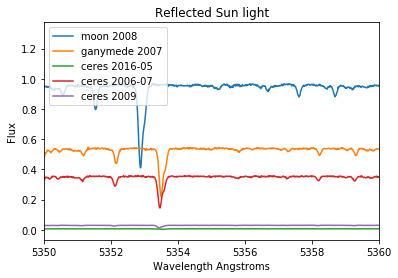

In [19]:
plt.plot(wave5, data5, label="moon 2008")
plt.plot(wave4, data4, label="ganymede 2007")
plt.plot(wave1, data1, label="ceres 2016-05")
plt.plot(wave2, data2, label="ceres 2006-07")
plt.plot(wave3, data3, label="ceres 2009")

plt.title("Reflected Sun light")
plt.ylabel("Flux")
plt.xlabel("Wavelength Angstroms")
plt.legend()
plt.xlim(5350, 5360)
plt.show()

In [20]:
# Calculate precisions for each half.
waves = [wave1, wave2, wave3, wave4]
fluxes = [data1, data2, data3, data4]

# Naviely calculate the precision with given value
xmin = 4000
xmid1 = 5300
xmid2 = 5350
xend = 6800

# First precision
print("First half of spectrum")
for w, f in zip(waves, fluxes):
    m = (w <= xmid1) & (w >= xmin)
    prec = Qcalculator.RVprec_calc(w[m], f[m])
    print(prec)
    
# Second half precision
print("\nSecond half of spectrum")
for w, f in zip(waves, fluxes):
    m = (w <= xend) & (w >= xmid2)
    prec = Qcalculator.RVprec_calc(w[m], f[m])
    print(prec)


First half of spectrum
568.4090342677548 m / s
85.6511068981741 m / s
152.63013885630428 m / s
73.06540450052373 m / s

Second half of spectrum
1077.5663665418817 m / s
191.81405475882127 m / s
361.85343610542196 m / s
152.11932278434435 m / s


In [21]:
# Figure you Resolution element
# Resample to 11000 with 3 pixel sampling
from eniric import resample
R=110000
mask = (wave1 <= 6500 ) & (wave1 >= 5350)
w = wave1[mask]
f = data1[mask]
wave = resample.log_resample(w, 3, R)
flux = np.interp(wave, w, f)
new_prec = Qcalculator.RVprec_calc(wave, flux)
print(new_prec)

1748.3341686509964 m / s


In [7]:
# Scaling all spectra to a SNR per resolution element to 
from eniric.snr_normalization import snr_constant_wav
snr = 200
wav_ref = 5356

const1 = snr_constant_wav(wave1, data1, wav_ref=wav_ref, snr = snr,sampling=3)
const2 = snr_constant_wav(wave2, data2, wav_ref=wav_ref, snr = snr,sampling=3)
const3 = snr_constant_wav(wave3, data3, wav_ref=wav_ref, snr = snr,sampling=3)
const4 = snr_constant_wav(wave4, data4, wav_ref=wav_ref, snr = snr,sampling=3)
const5 = snr_constant_wav(wave5, data5, wav_ref=wav_ref, snr = snr,sampling=3)
const6 = snr_constant_wav(wave5, data5/const5, wav_ref=wav_ref, snr = snr,sampling=3)



	Sanity Check: The S/N for the reference model was of 0.14.
	Sanity Check: The S/N for the reference model was of 1.03.
	Sanity Check: The S/N for the reference model was of 0.30.
	Sanity Check: The S/N for the reference model was of 1.27.
	Sanity Check: The S/N for the reference model was of 1.70.
	Sanity Check: The S/N for the reference model was of 200.00.


In [8]:
# First precision
print("First half of spectrum")
consts = [const1, const2, const3, const4, const5]
for w, f, c in zip(waves, fluxes, consts):
    m = (w <= xmid1) & (w >= xmin)
    prec = Qcalculator.RVprec_calc(w[m], f[m]/c)
    print(prec)
    
# Second half precision
print("\nSecond half of spectrum")
for w, f, c in zip(waves, fluxes,consts):
    m = (w <= xend) & (w >= xmid2)
    prec = Qcalculator.RVprec_calc(w[m], f[m]/c)
    print(prec)


First half of spectrum
0.4075611663368125 m / s
0.4409049508460873 m / s
0.22940609281716742 m / s
0.4639657076827486 m / s

Second half of spectrum
0.7726376245045303 m / s
0.9873983995241254 m / s
0.5438728090784948 m / s
0.9659585092561169 m / s


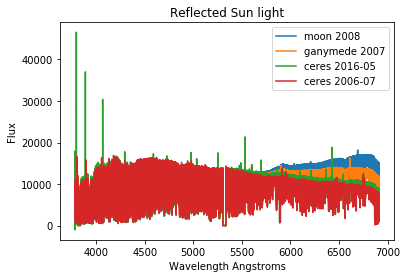

In [9]:
plt.plot(wave5, data5/const5, label="moon 2008")
plt.plot(wave4, data4/const4, label="ganymede 2007")
plt.plot(wave1, data1/const1, label="ceres 2016-05")
plt.plot(wave2, data2/const2, label="ceres 2006-07")
#plt.plot(wave3, data3/const3, label="ceres 2009")

plt.title("Reflected Sun light")
plt.ylabel("Flux")
plt.xlabel("Wavelength Angstroms")
plt.legend()
#plt.xlim(5350, 5360)
plt.show()

In [ ]:
# Break into small chunks and divide by SNR at 5350nm
chunks = np.arange(wave1[0], wave1[-1] + 2, 100)
print(len(chunks))
waves = [wave1, wave2, wave3, wave4]
fluxes = [data1, data2, data3, data4]
labels = ["ceres 06", "ceres 06-2", "ganymede", "moon"]

for w, f, c, l in zip(waves, fluxes, consts, labels):
    prec = []
    center = []
    for ii in range(len(chunks)-1):
        xmin = chunks[ii]
        xmax = chunks[ii+1]
        m = (w <= xmax) & (w >= xmin)
        print(f[m]/c)
        prec.append(Qcalculator.RVprec_calc(w[m], f[m]/c).value)
        center.append((xmax + xmin)/2)
    plt.plot(center, prec, "*", label=l)

plt.legend()
plt.xlabel("Wavelength")
plt.ylabel("Precision (m/s)")
plt.title("100 SNR at ~5350 nm")


In [ ]:
from astropy.io import fits
data1, hdr1 = fits.getdata("/home/jneal/.handy_spectra/harps/ceres_2006-05-22_s1d.fits", header=True)
wave1 = get_wavelength(hdr1, convert=False)
data2, hdr2 = fits.getdata("/home/jneal/.handy_spectra/harps/ceres_2006-07-15_s1d.fits", header=True)
wave2 = get_wavelength(hdr2, convert=False)
data3, hdr3 = fits.getdata("/home/jneal/.handy_spectra/harps/ceres_2009-02-08_s1d.fits", header=True)
wave3 = get_wavelength(hdr3, convert=False)
data4, hdr4 = fits.getdata("/home/jneal/.handy_spectra/harps/ganymede_2007-04-12_s1d.fits", header=True)
wave4 = get_wavelength(hdr4, convert=False)
data5, hdr5 = fits.getdata("/home/jneal/.handy_spectra/harps/moon_2008-08-08_s1d.fits", header=True)
wave5 = get_wavelength(hdr5, convert=False)

In [ ]:
# Break into small chunks and divide by SNR at 5350nm
chunks = np.arange(wave1[0], 5300, 100)
chunks2 = np.arange(5350, wave1[-1], 100)
waves = [wave1, wave2, wave3, wave4]
fluxes = [data1, data2, data3, data4]
labels=["ceres 06", "ceres 06-2", "ganymede", "moon"]
colors = ["C1", "C2", "C3", "C4"]

for w, f, c, l, cl in zip(waves, fluxes, consts, labels, colors):
    print("label", l)
    prec = []
    center = []
    prec2 = []
    center2 = []
    for ii in range(len(chunks)-1):
        print("ii", ii)
        xmin = chunks[ii]
        xmax = chunks[ii+1]
        
        this_center = (xmax + xmin)/2
        center.append(this_center)
        # print(len(w), len(f))
        scale = snr_constant_wav(wav=w, flux=f, wav_ref=this_center)
        #print("scale", scale)
        m = (w <= xmax) & (w >= xmin)
        prec.append(Qcalculator.RVprec_calc(w[m], f[m]/scale).value)
    
    for ii in range(len(chunks2)-1):
        print("ii", ii)
        xmin = chunks2[ii]
        xmax = chunks[ii+1]
        
        this_center = (xmax + xmin)/2
        center2.append(this_center)
        # print(len(w), len(f))
        scale = snr_constant_wav(wav=w, flux=f, wav_ref=this_center)
        #print("scale", scale)
        m = (w <= xmax) & (w >= xmin)
        prec2.append(Qcalculator.RVprec_calc(w[m], f[m]/scale).value)
        print(scale, prec2[-1])
        
        
    plt.plot(center, prec, "*", label=l, color=cl)
    plt.plot(center2, prec2, "*", color=cl)


plt.legend()
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Precision $\sigma$ (m/s)")
plt.title("100 SNR at center of each band")
plt.show()

# How does Sampling affect the precision?

Hmmm it seems to be inverse-squarely correlated again....

Is higher sampling affecting the dirivitives...

In [ ]:
R=110000
mask = (wave1 <= 6500 ) & (wave1 >= 5350)
w = wave1[mask]
f = data1[mask]

samples = [0.5, 1, 3, 5, 7, 10]
sample_prec = []
for sampling in samples:

    wave = resample.log_resample(w, sampling, R)
    flux = np.interp(wave, w, f)
    sample_prec.append(Qcalculator.RVprec_calc(wave, flux).value)
plt.plot(samples, sample_prec)
plt.xlabel("Sampling")
plt.ylabel("precision")
plt.show()

# Spectral Quality of spectra

The spectra quality is flux independent.

In [ ]:
quality = Qcalculator.quality

# Break into small chunks 
chunks = np.arange(wave1[0], 5300, 100)
chunks2 = np.arange(5350, wave1[-1], 100)
waves = [wave1, wave2, wave3, wave4]
fluxes = [data1, data2, data3, data4]
labels=["ceres 06", "ceres 06-2", "ganymede", "moon"]
colors = ["C1", "C2", "C3", "C4"]

for w, f, c, l, cl in zip(waves, fluxes, consts, labels, colors):
    print("label", l)
    qual = []
    center = []
    qual2 = []
    center2 = []
    for ii in range(len(chunks)-1):
        xmin = chunks[ii]
        xmax = chunks[ii+1]
        
        this_center = (xmax + xmin)/2
        center.append(this_center)
        # print(len(w), len(f))
        #scale = snr_constant_wav(wav=w, flux=f, wav_ref=this_center)
        #print("scale", scale)
        m = (w <= xmax) & (w >= xmin)
        # prec.append(Qcalculator.RVprec_calc(w[m], f[m]).value)
        qual.append(quality(w[m], f[m]))
        print("ii", ii, "quality =", qual[-1])
    
    for ii in range(len(chunks2)-1):
        xmin = chunks2[ii]
        xmax = chunks[ii+1]
        
        this_center = (xmax + xmin)/2
        center2.append(this_center)
        # print(len(w), len(f))
        #scale = snr_constant_wav(wav=w, flux=f, wav_ref=this_center)
        #print("scale", scale)
        m = (w <= xmax) & (w >= xmin)
        # prec2.append(Qcalculator.RVprec_calc(w[m], f[m]).value)
        qual2.append(quality(w[m], f[m]))
        print("ii", ii, "quality2 =", qual2[-1])
             
    plt.plot(center, qual, "*", label=l, color=cl)
    plt.plot(center2, qual2, "*", color=cl)

plt.legend()
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Quality (100 nm)")
plt.title("Quality")
plt.show()